In [2]:
from typing import Union
from io import TextIOWrapper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

In [4]:
class PieHeatmapPlot:
    def __init__(
        self,
        data: Union[pd.DataFrame, np.ndarray,
                    TextIOWrapper, str] = "./data.txt",
        xTitle: str = None,
        xLabels: list[str] = None,
        yTitle: str = None,
        yLabels: list[str] = None,
        piedata: Union[pd.DataFrame, np.ndarray] = None,
        pieLabels: list[str] = None,
        output: str = "."
    ):
        self.xTitle = xTitle
        self.xLabels = xLabels
        self.yTitle = yTitle
        self.yLabels = yLabels
        self.pieLabels = pieLabels
        self.pieData = piedata
        self.data = self.__parseData(data)
        self.xIndex = np.array(pd.Categorical(self.xLabels).codes)
        self.yIndex = np.array(pd.Categorical(self.yLabels).codes)

    def __parseData(self, data: Union[pd.DataFrame, np.ndarray, TextIOWrapper, str]):
        """
        Parses data into a pandas DataFrame
        :param data: pandas DataFrame, file object, or string
        :return: pandas DataFrame
        """

        # 如果是数据框，则数据至少要有4列
        # 前两列分别表示行和列的标签，无所谓顺序，但是列名必须是 X (列) 和 Y (行)
        # 其余的列表示 (X,Y) 格子中的饼图数据
        if isinstance(data, pd.DataFrame):
            assert len(data.shape) == 2 and data.shape[1] >= 4,\
                "For Dataframe, data must be have at least 4 columns"
            assert 'X' in data.columns and 'Y' in data.columns,\
                "For Dataframe, data must have columns named 'X' and 'Y'"
            self.xLabels = data.loc[:, 'X']
            self.yLabels = data.loc[:, 'Y']
            self.pieData = self.data.drop(['X', 'Y'], axis=1)
            self.pieLabels = self.pieData.columns
            return data
        elif isinstance(data, TextIOWrapper) or isinstance(data, str):
            temp = pd.read_csv(data, sep="\t")
            assert len(temp.shape) == 2 and temp.shape[1] >= 4,\
                "For Dataframe, data must be have at least 4 columns"
            assert 'X' in data.columns and 'Y' in data.columns,\
                "For Dataframe, data must have columns named 'X' and 'Y'"
            self.xLabels = data.loc[:, 'X']
            self.yLabels = data.loc[:, 'Y']
            self.pieData = self.data.drop(['X', 'Y'], axis=1)
            self.pieLabels = self.pieData.columns
            return temp
        # 如果是Numpy矩阵，则数据至少有2列
        # 每行的数据都表示饼图的数据
        # 指定的名字的长度必须和数据的维度一致
        # 否则，列名和行名使用默认的名字
        elif isinstance(data, np.ndarray):
            assert len(data.shape) == 2 and data.shape[1] > 1,\
                "For numpy array, data must be a 2D array and have at least 2 columns"
            if not self.pieLabels:
                self.pieLabels = ["Type"+str(i+1)
                                for i in np.arange(data.shape[1])]
            if not self.xLabels:
                self.xLabels = ["Column"+str(i+1)
                                for i in np.arange(data.shape[1])]
            if not self.yLabels:
                self.yLabels = ["Row"+str(i+1)
                                for i in np.arange(data.shape[0])]
            # 如果指定了列名和行名，那么必须和数据的维度一致
            if self.xLabels and self.yLabels:
                if not len(self.xLabels) == data.shape[1]:
                    warnings.warn(
                        "The length of xLabels must be equal to the number of columns in data. Default colnames will be used instead.")
                    self.xLabels = ["Column"+str(i+1)
                                    for i in np.arange(data.shape[1])]
                if not len(self.yLabels) == data.shape[0]:
                    warnings.warn(
                        "The length of yLabels must be equal to the number of rows in data. Default rownames will be used instead.")
                    self.yLabels = ["Row"+str(i+1)
                                    for i in np.arange(data.shape[0])]
            self.pieData = data
            temp = pd.DataFrame(data)
            return temp
        else:
            raise TypeError(
                "Data must be a pandas DataFrame, a file object, or a path")

    def __hex_to_rgb(self, value):
        """
        Converts hex to rgb colours
        :param value: string of hex code
        :return: tuple of RGB values
        """
        value = value.strip("#")  # removes hash symbol if present
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

    def __rgb_to_dec(self, value):
        """
        Converts rgb to decimal colours
        :param value: tuple of RGB values
        :return: tuple of decimal values
        """
        return [v/256 for v in value]

    def __get_continuous_cmap(self, hex_list, float_list=None):
        """
        Creates a continuous colour map from a list of hex colours
        :params hex_list: list of hex colours
        :params float_list: list of floats between 0 and 1
        :return: matplotlib colour map
        """
        rgb_list = [self.__rgb_to_dec(self.__hex_to_rgb(i)) for i in hex_list]
        if float_list:
            pass
        else:
            float_list = list(np.linspace(0, 1, len(rgb_list)))
        cdict = dict()
        for num, col in enumerate(['red', 'green', 'blue']):
            col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]]
                        for i in range(len(float_list))]
            cdict[col] = col_list
        cmp = mcolors.LinearSegmentedColormap(
            'my_cmp', segmentdata=cdict, N=256)
        return cmp

    def plot(self):
        """
        Plots a heatmap with pie charts
        """

        colors = plt.get_cmap('Blues')(np.linspace(0.2, 0.7, 3))
        fig, ax = plt.subplots(figsize=(len(self.yLabels), len(self.xLabels)))
        ax.set_aspect(1)

        for row_index, row in enumerate(self.yIndex, 0):
            for column_index, column in enumerate(self.xIndex, 0):
                ax.pie(
                    x=list[self.pieData.iloc[row_index, :]],
                    radius=0.4,
                    center=(column, row),
                    colors=colors,
                    wedgeprops={"linewidth": 1, "edgecolor": "white"},
                    frame=False
                )

        ax.imshow(np.random.rand(len(set(self.yIndex)), len(set(self.xIndex))), cmap=self.__get_continuous_cmap(
            ["#ffffff", "#ffffff"]))

        ax.set_xticks(np.arange(len(set(self.xIndex))), labels=set(self.xLabels))
        ax.set_yticks(np.arange(len(set(self.yIndex))), labels=set(self.yLabels))
        ax.tick_params(top=True, bottom=False,
                       labeltop=True, labelbottom=False)

        plt.setp(ax.get_xticklabels(), rotation=30,
                 ha="left", rotation_mode="anchor")

        # ax.spines[:].set_visible(True)

        ax.set_xticks(np.arange(len(self.xIndex)+1)-.5, minor=True)
        ax.set_yticks(np.arange(len(self.yIndex)+1)-.5, minor=True)

        ax.grid(which="major", color="none", linestyle='-', linewidth=0)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
        ax.tick_params(which="major", top=False,
                       bottom=False, left=False, right=False)
        ax.tick_params(which="minor", top=True,
                       bottom=False, left=True, right=False)

        plt.legend(['high', 'middle', 'low'], loc=[1.05, 0.5])
        fig.suptitle("Throwing success", size=12)
        ax.set_xlabel(self.xTitle)
        ax.set_ylabel(self.yTitle)
        plt.style.use('_mpl-gallery')
        plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

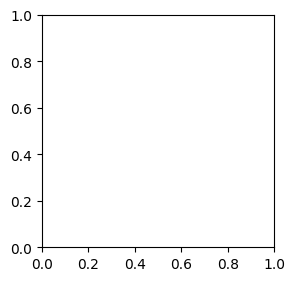

In [6]:
plot = PieHeatmapPlot(np.random.rand(3,4))
plot.plot()

In [3]:
plt.get_cmap('Blues')(np.linspace(0.2, 0.7, 3))

array([[0.81411765, 0.88392157, 0.94980392, 1.        ],
       [0.49803922, 0.7254133 , 0.85613226, 1.        ],
       [0.17914648, 0.49287197, 0.73542484, 1.        ]])